# Information Retrieval

In [1]:
import ParserCACM
import TextRepresenter
import indexation
import modeles
from query import QueryParserCACM
import evaluation
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import operator
# Auto reload the imported modules when running cells
%load_ext autoreload 
%autoreload 2

""" Some info to remember when testing:
- Query 10 is about parallel computation
- Doc 46 is about parallelism too
"""

# Constants:
srcFolder = "cacm" 
srcFile = "cacm.txt"
qryFile = "cacm.qry"
relFile = "cacm.rel"
gendata = "gendata" #output folder
indexName = "cacm"
docId = 46
queryId = np.random.randint(1,60)
wordTest = "logic"

cacm_txt = os.path.join(srcFolder, srcFile)
cacm_qry = os.path.join(srcFolder, qryFile)
cacm_rel = os.path.join(srcFolder, relFile)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Testing the indexation:

In [39]:
# Construct the index:
idx = indexation.Index(indexName, gendata)
stemmer = TextRepresenter.PorterStemmer()
idx.indexation(cacm_txt, ParserCACM.ParserCACM(), stemmer)

Performing the indexation...
1st pass: build the index...
2nd pass: build the inverted index...
Finished.


In [40]:
print("\n###### Testing the index: ###### ")
print("Retrieve common stems in doc %d:" % docId)
stems = sorted(idx.getTfsForDoc(docId).items(), key=operator.itemgetter(1), reverse=True)
print([stem for stem, freq in stems[:10]])
print("""Should look like
> “The tendency towards increased parallelism in
> computers is noted.  Exploitation of this parallelism
> presents a number of new problems in machine design
> and in programming systems...”""")

print("\nRetrieve docs that contains 'logic'")
docs = idx.getTfsForStem("logic") 
print(docs)
print("Should include doc 63 and 46:", (63 in docs.keys() and 46 in docs.keys()))


###### Testing the index: ###### 
Retrieve common stems in doc 46:
['program', 'programm', 'problem', 'requir', 'stretch', 'parallel', 'logic', 'built', 'techniqu', 'describ']
Should look like
> “The tendency towards increased parallelism in
> computers is noted.  Exploitation of this parallelism
> presents a number of new problems in machine design
> and in programming systems...”

Retrieve docs that contains 'logic'
{2817: 1, 3154: 6, 1030: 1, 2568: 1, 2313: 2, 3082: 1, 2060: 1, 2322: 1, 2067: 1, 22: 1, 2845: 1, 30: 1, 2848: 3, 2851: 1, 2054: 1, 3111: 1, 1834: 1, 1324: 1, 46: 2, 1327: 1, 2952: 1, 2871: 4, 3133: 5, 63: 2, 320: 8, 1602: 2, 2230: 1, 2888: 1, 3147: 1, 1101: 1, 2127: 2, 850: 1, 595: 2, 753: 1, 2145: 1, 2146: 2, 1381: 1, 2406: 3, 1383: 2, 1103: 1, 2931: 5, 1908: 1, 1398: 1, 3194: 1, 1916: 1, 2943: 1, 1155: 2, 1462: 1, 1928: 4, 1677: 1, 1718: 1, 1170: 1, 1173: 1, 2209: 1, 1700: 1, 2726: 3, 679: 2, 1195: 1, 1965: 1, 1456: 1, 2227: 1, 2484: 1, 1974: 6, 1208: 1, 1465: 1, 3008

In [56]:
print("Links from the 1st article:", sorted(idx.getSuccNodes('1')))
print("(Should be [43, 53, 91, ..., 1883, 1982, 3184])")
print("\nLinks from the 2nd article:", idx.getSuccNodes('2'))
print("(Should be empty)")

print("\nLinks to the 1st article:", sorted(idx.getPrevNodes('1')))
print("(Should be [43, 53, 91, ..., 1883, 1982, 3184])")
print("\nLinks to the 43rd article:", sorted(idx.getPrevNodes('43')))
print("(Should be [1, 205])")


Links from the 1st article: [43, 53, 91, 100, 123, 164, 165, 196, 205, 210, 214, 324, 398, 410, 642, 669, 1273, 1883, 1982, 3184]
(Should be [43, 53, 91, ..., 1883, 1982, 3184])

Links from the 2nd article: []
(Should be empty)

Links to the 1st article: [43, 53, 91, 100, 123, 164, 165, 196, 205, 210, 214, 324, 398, 410, 642, 669, 1273, 1883, 1982, 3184]
(Should be [43, 53, 91, ..., 1883, 1982, 3184])

Links to the 43rd article: [1, 205]
(Should be [1, 205])


In [13]:
# Choosing what to test:
test_binaryweighter = True
test_tfidfweighter = True
test_queryparser = True
test_PRrecallmeasure = True
test_averageprecision = True
test_eval_ir_model = True
test_unigram_model = True
test_okapi = True
gridsearch_language = True

## Testing the weighters:

In [14]:
query = stemmer.getTextRepresentation(" Parallel languages; languages for parallel computation")

if test_binaryweighter:
    print("\n#####Testing BinaryWeighter: #####")

    bw = modeles.BinaryWeighter(idx)
    print("bw.getDocWeightsForDoc(",docId,"):", 
        bw.getDocWeightsForDoc(docId))
    print("\nbw.getDocWeightsForStem('"+wordTest+"'):", 
        bw.getDocWeightsForStem(wordTest))
    print("\nbw.getWeightsForQuery(' Parallel languages; languages for parallel computation'):", 
        bw.getWeightsForQuery(query))

    print("\n#####Testing Vectoriel with BinaryWeighter: #####")
    vect = modeles.Vectoriel(idx, bw)
    print("Top 10 documents for the previous query:")
    print("""Should include some of the following docs: 1043, 1188, 1306, 
    1358, 1396, 1491, 1923, 2246, 2316, 2527, 2699, 2710, 2715, 2716, 
    2906, 2923, 2956, 3073, 3150, """)
    print(vect.getRanking(query)[:10])
else:
    print("\n##### Skipping the test of BinaryWeighter #####")
    


#####Testing BinaryWeighter: #####
bw.getDocWeightsForDoc( 46 ): {'built': 1, 'requir': 2, 'techniqu': 1, 'describ': 1, 'present': 1, 'independ': 1, 'stretch': 2, 'programm': 3, 'multiprogramm': 1, 'lowri': 1, 'note': 1, 'supervisori': 1, 'concurr': 1, 'mcdonough': 1, 'machin': 1, 'compil': 1, 'codd': 1, 'tendenc': 1, 'system': 1, 'place': 1, 'problem': 3, 'comput': 1, 'parallel': 2, 'minimum': 1, 'balanc': 1, 'feasibl': 1, 'consider': 1, 'logic': 2, 'design': 1, 'execut': 1, 'exploit': 1, 'increas': 1, 'program': 4, 'scalzi': 1, 'discuss': 1, 'burden': 1, 'met': 1, 'success': 1, 'combin': 1, 'carefulli': 1, 'number': 1}

bw.getDocWeightsForStem('logic'): {2817: 1, 3154: 6, 1030: 1, 2568: 1, 2313: 2, 3082: 1, 2060: 1, 2322: 1, 2067: 1, 22: 1, 2845: 1, 30: 1, 2848: 3, 2851: 1, 2054: 1, 3111: 1, 1834: 1, 1324: 1, 46: 2, 1327: 1, 2952: 1, 2871: 4, 3133: 5, 63: 2, 320: 8, 1602: 2, 2230: 1, 2888: 1, 3147: 1, 1101: 1, 2127: 2, 850: 1, 595: 2, 753: 1, 2145: 1, 2146: 2, 1381: 1, 2406: 3, 1383

In [15]:
tfidfWeighter = modeles.TfidfWeighter(idx)
vect = modeles.Vectoriel(idx, tfidfWeighter)

if test_tfidfweighter:
    print("\n###### Testing TfidfWeighter: ###### ")
    print("tfidfWeighter.getDocWeightsForDoc(", docId, "):",
         tfidfWeighter.getDocWeightsForDoc(docId))
    print("\ntfidfWeighter.getDocWeightsForStem(\"logic\"):",
         tfidfWeighter.getDocWeightsForStem(wordTest))
    print("\ntfidfWeighter.getWeightsForQuery(query):",
         tfidfWeighter.getWeightsForQuery(query))
    print("\n###### Testing Vectoriel with TfidfWeighter: ###### ")
    print("Top 10 documents for the query:")
    print(vect.getRanking(query)[:10])
else:
    print("\n##### Skipping the test of TfidfWeighter #####")


###### Testing TfidfWeighter: ###### 
tfidfWeighter.getDocWeightsForDoc( 46 ): {'built': 1, 'requir': 2, 'techniqu': 1, 'describ': 1, 'present': 1, 'independ': 1, 'stretch': 2, 'programm': 3, 'multiprogramm': 1, 'lowri': 1, 'note': 1, 'supervisori': 1, 'concurr': 1, 'mcdonough': 1, 'machin': 1, 'compil': 1, 'codd': 1, 'tendenc': 1, 'system': 1, 'place': 1, 'problem': 3, 'comput': 1, 'parallel': 2, 'minimum': 1, 'balanc': 1, 'feasibl': 1, 'consider': 1, 'logic': 2, 'design': 1, 'execut': 1, 'exploit': 1, 'increas': 1, 'program': 4, 'scalzi': 1, 'discuss': 1, 'burden': 1, 'met': 1, 'success': 1, 'combin': 1, 'carefulli': 1, 'number': 1}

tfidfWeighter.getDocWeightsForStem("logic"): {2817: 1, 3154: 6, 1030: 1, 2568: 1, 2313: 2, 3082: 1, 2060: 1, 2322: 1, 2067: 1, 22: 1, 2845: 1, 30: 1, 2848: 3, 2851: 1, 2054: 1, 3111: 1, 1834: 1, 1324: 1, 46: 2, 1327: 1, 2952: 1, 2871: 4, 3133: 5, 63: 2, 320: 8, 1602: 2, 2230: 1, 2888: 1, 3147: 1, 1101: 1, 2127: 2, 850: 1, 595: 2, 753: 1, 2145: 1, 2146: 

## Testing the QueryParser

In [16]:
if test_queryparser:
    print("\n###### Testing QueryParserCACM: ###### ")
    qp = QueryParserCACM(cacm_qry, cacm_rel)
    query = qp.nextQuery()
    print("Searching for query #%d:" % queryId)
    while query is not None and query.getID() != str(queryId):
        #print(query)
        #print(20*'-')
        query = qp.nextQuery()

    print("Query:", query)
    queryTxt = stemmer.getTextRepresentation(query.getText())
    print("\nCompute scores:")
    scores = vect.getRanking(queryTxt)
    print(scores[:10])
    print("Done.")
else:
    print("\n##### Skipping the test of QueryParserCACM #####")


###### Testing QueryParserCACM: ###### 
Searching for query #40:
Query: Query {id=40, txt='List all articles dealing with data types in the following languages:
Pascal, CLU, Alphard, Russell, Ada, ALGOL 68, EL1.  List any other languages
that are referenced frequently in papers on the above languages (e.g. catch
any languages with interesting type structures that I might have missed).
', relevances=[1614, 2126, 2148, 2265, 2651, 2939, 2940, 2941, 2956, 2958]}

Compute scores:
[('2651', 0.16998513268596493), ('2148', 0.15637749139694951), ('2940', 0.14532765113888962), ('2939', 0.14327563776307761), ('2295', 0.13530084471012979), ('1588', 0.13312969259625229), ('1485', 0.12898160751636753), ('2958', 0.1252088721084326), ('1860', 0.12216591671864682), ('2857', 0.11897295821522855)]
Done.


## Testing precision/recall measure:



###### Testing evaluation.PrecisionRecallMeasure: ###### 
Searching for query # [7, 10, 25]
Query: Query {id=7, txt='I am interested in distributed algorithms - concurrent programs in
which processes communicate and synchronize by using message passing.
Areas of particular interest include fault-tolerance and techniques
for understanding the correctness of these algorithms.
', relevances=[1198, 1338, 1877, 1960, 2150, 2228, 2256, 2280, 2320, 2342, 2376, 2482, 2578, 2597, 2618, 2685, 2700, 2777, 2865, 2866, 2895, 2912, 2941, 3043, 3082, 3128, 3141, 3148]}
Retrieve scores...
CPU times: user 340 ms, sys: 72 ms, total: 412 ms
Wall time: 538 ms
Create PrecisionRecallMeasure object
Evaluate the scores.
This query has 28 relevant results
   i |found| precision | recall
    1|   1 | 1.000000  |0.035714
    2|   2 | 1.000000  |0.071429
    4|   3 | 0.750000  |0.107143
   12|   4 | 0.333333  |0.142857
   13|   5 | 0.384615  |0.178571
   19|   6 | 0.315789  |0.214286
   21|   7 | 0.333333  |0.25

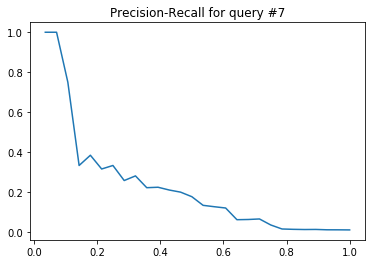

--------------------
Query: Query {id=10, txt='Parallel languages; languages for parallel computation
', relevances=[46, 141, 392, 950, 1158, 1198, 1262, 1380, 1471, 1601, 1613, 1747, 1795, 1811, 2060, 2150, 2256, 2289, 2342, 2376, 2433, 2618, 2664, 2685, 2700, 2714, 2777, 2785, 2851, 2895, 2896, 2912, 3039, 3075, 3156]}
Retrieve scores...
CPU times: user 400 ms, sys: 160 ms, total: 560 ms
Wall time: 639 ms
Create PrecisionRecallMeasure object
Evaluate the scores.
This query has 35 relevant results
   i |found| precision | recall
    1|   1 | 1.000000  |0.028571
    2|   2 | 1.000000  |0.057143
    3|   3 | 1.000000  |0.085714
    4|   4 | 1.000000  |0.114286
    5|   5 | 1.000000  |0.142857
    8|   6 | 0.750000  |0.171429
    9|   7 | 0.777778  |0.200000
   10|   8 | 0.800000  |0.228571
   11|   9 | 0.818182  |0.257143
   12|  10 | 0.833333  |0.285714
   13|  11 | 0.846154  |0.314286
   18|  12 | 0.666667  |0.342857
   19|  13 | 0.684211  |0.371429
   26|  14 | 0.538462  |0.400000
  

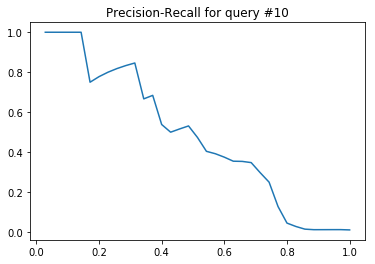

--------------------
Query: Query {id=25, txt='Performance evaluation and modelling of computer systems
', relevances=[268, 757, 963, 1408, 1518, 1526, 1533, 1572, 1653, 1698, 1719, 1805, 1892, 1901, 2085, 2095, 2218, 2277, 2318, 2319, 2358, 2373, 2434, 2452, 2535, 2582, 2667, 2668, 2669, 2681, 2741, 2765, 2798, 2818, 2831, 2859, 2862, 2863, 2881, 2918, 2928, 2984, 2988, 2996, 3006, 3048, 3059, 3067, 3088, 3089, 3119]}
Retrieve scores...
CPU times: user 344 ms, sys: 164 ms, total: 508 ms
Wall time: 580 ms
Create PrecisionRecallMeasure object
Evaluate the scores.
This query has 51 relevant results
   i |found| precision | recall
    1|   1 | 1.000000  |0.019608
    2|   2 | 1.000000  |0.039216
    4|   3 | 0.750000  |0.058824
    5|   4 | 0.800000  |0.078431
    6|   5 | 0.833333  |0.098039
    7|   6 | 0.857143  |0.117647
   11|   7 | 0.636364  |0.137255
   14|   8 | 0.571429  |0.156863
   16|   9 | 0.562500  |0.176471
   17|  10 | 0.588235  |0.196078
   18|  11 | 0.611111  |0.215686
 

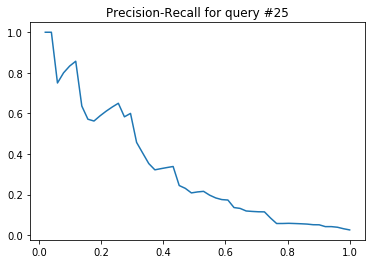

--------------------
Done.


In [17]:
if test_PRrecallmeasure:
    print("\n###### Testing evaluation.PrecisionRecallMeasure: ###### ")
    queryChosen = np.random.randint(1, 50, size=10)
    queryChosen =[7, 10, 25]#, 14, 26, 27, 42, 43] # lots of relevant results
    qp = QueryParserCACM(cacm_qry, cacm_rel)
    query = qp.nextQuery()
    print("Searching for query #", queryChosen)
    while query is not None :
        if int(query.getID()) in queryChosen:
            print("Query:", query)
            queryTxt = stemmer.getTextRepresentation(query.getText())
            print("Retrieve scores...")
            %time ranking = vect.getRanking(queryTxt)
            print("Create PrecisionRecallMeasure object")
            irlist = evaluation.IRList(query, ranking)
            precisRecall = evaluation.PrecisionRecallMeasure(irlist)
            print("Evaluate the scores.")
            pr = precisRecall.eval(verbose=True, nbLevel=100) # (recall, precision)
            precision = [p for r,p in pr]
            recall = [r for r,p in pr]
            plt.plot(recall, precision)
            plt.title("Precision-Recall for query #"+query.getID())
            plt.show()
            print(20*'-')


        query = qp.nextQuery()
    print("Done.")
else:
    print("\n##### Skipping the test of PrecisionRecallMeasure #####")

## Testing average precision:

In [18]:
if test_averageprecision:
    print("\n###### Testing evaluation.AveragePrecision: ###### ")
    queryChosen = np.random.randint(1, 50, size=10)
    #queryChosen =[7, 10, 14, 29]#, 25, 26, 27, 42, 43] # lots of relevant results
    qp = QueryParserCACM(cacm_qry, cacm_rel)
    query = qp.nextQuery()
    print("Searching for query #",queryChosen, "\n")
    while query is not None :
        if int(query.getID()) in queryChosen:
            print("Query:", query)
            queryTxt = stemmer.getTextRepresentation(query.getText())
            print("Retrieve scores...")
            scores = vect.getRanking(queryTxt)
            irlist = evaluation.IRList(query, scores)
            average_measure = evaluation.AveragePrecision(irlist)
            print("Evaluate the scores.")
            average_prec = average_measure.eval(verbose=True)
            print("Average precision: %f" % average_prec)
            print(20*'-')

        query = qp.nextQuery()
    print("Done.")
else:
    print("\n##### Skipping the test of AveragePrecision #####")


###### Testing evaluation.AveragePrecision: ###### 
Searching for query # [31  7 40 40 37 35  4 49 17  9] 

Query: Query {id=4, txt='I'm interested in mechanisms for communicating between disjoint processes,
possibly, but not exclusively, in a distributed environment.  I would
rather see descriptions of complete mechanisms, with or without implementations,
as opposed to theoretical work on the abstract problem.  Remote procedure
calls and message-passing are examples of my interests.
', relevances=[1749, 1811, 2256, 2371, 2597, 2796, 2912, 3043, 3073, 3082, 3127, 3128]}
Retrieve scores...
Evaluate the scores.
This query has 12 relevant results
   i |found| precision
    2|   1 | 0.500000
    7|   2 | 0.285714
   38|   3 | 0.078947
  109|   4 | 0.036697
  110|   5 | 0.045455
  111|   6 | 0.054054
  164|   7 | 0.042683
  374|   8 | 0.021390
  479|   9 | 0.018789
  834|  10 | 0.011990
  905|  11 | 0.012155
 3034|  12 | 0.003955
Average precision: 0.092653
--------------------
Query: Quer

## Testing EvalIRModel:

In [19]:
if test_eval_ir_model:
    print("\n###### Testing evaluation.EvalIRModel: ###### ")
    queryChosen = np.random.randint(1, 50, size=50)
    #queryChosen =[7, 10, 14]#, 25, 26, 27, 42, 43] # lots of relevant results
    queries = []
    qp = QueryParserCACM(cacm_qry, cacm_rel)
    query = qp.nextQuery()
    print("Searching for queries #",queryChosen, "...")
    while query is not None :
        if int(query.getID()) in queryChosen:
            queries.append(query)
        query = qp.nextQuery()
    print("Found queries")
    irmodels = {"vectoriel": modeles.Vectoriel(idx, tfidfWeighter)}
    measures = {"averagePrecision": evaluation.AveragePrecision}
    eval_model = evaluation.EvalIRModel(queries, irmodels, measures)
    print("Calling eval()...")
    print(eval_model.eval(verbose=False))
    print("Done.")
else:
    print("\n##### Skipping the test of EvalIRModel #####")


###### Testing evaluation.EvalIRModel: ###### 
Searching for queries # [45  1 37 45 14  8 10 21 40 48 13 14 17 34 16  7 17 32 32 33 28 30 27 13 19
 23 31 40 17  9  4 32 25 18  6  5 24 21 42 15 27 48 35 21 29 16 10 18 14 44] ...
Found queries
Calling eval()...
{('vectoriel', 'averagePrecision'): (0.28622864552411087, 0.21934740252403967)}
Done.


## Testing the unigram language model:

In [20]:
if test_unigram_model:
    print("\n###### Testing Unigram language: ###### ")
    queryChosen = np.random.randint(1, 50, size=3)
    #queryChosen =[7, 10, 14]#, 25, 26, 27, 42, 43] # lots of relevant results
    queries = []
    relevants = {} #dict of {query id : list of relevant doc id}
    qp = QueryParserCACM(cacm_qry, cacm_rel)
    query = qp.nextQuery()
    print("Searching for queries #",queryChosen, "...")
    while query is not None :
        if int(query.getID()) in queryChosen:
            queries.append(query)
            relevants[query.getID()] = list(query.getRelevants().keys())
            #print(query)
        query = qp.nextQuery()
    print("Found queries")
    model = modeles.UnigramLanguage(idx, 0.8)
    for q, (q_id, relev) in zip(queries, relevants.items()):
        print(q)
        print("Scores for 3 relevant docs:")
        for doc_id in np.random.choice(relev, size=3):
            print(doc_id, model.score(stemmer.getTextRepresentation(q.getText()), doc_id))
        print("Scores for 3 random docs:")
        for doc_id in np.random.choice(idx.getDocsID(), size=3):
            if doc_id in relev:
                print("Doc #", doc_id, "Relevant doc")
            else:
                stems = ','.join(idx.getTfsForDoc(doc_id).keys())
                print("Irrelevant doc #", doc_id, stems)
                print("Score for this doc:", 
                      model.score(stemmer.getTextRepresentation(q.getText()), doc_id))
        print(20*'-')
    print("Done.")
else:
    print("\n##### Skipping the test of LanguageModel #####")


###### Testing Unigram language: ###### 
Searching for queries # [27 30 47] ...
Found queries
Query {id=27, txt='Memory management aspects of operating systems
', relevances=[1641, 1642, 1750, 1752, 1879, 1884, 1901, 2095, 2297, 2435, 2481, 2498, 2560, 2596, 2669, 2734, 2747, 2768, 2798, 2818, 2859, 2864, 2902, 2918, 2955, 2983, 2988, 3000, 3052]}
Scores for 3 relevant docs:
1353 -39.028716553
1353 -39.028716553
1353 -39.028716553
Scores for 3 random docs:
Irrelevant doc # 498 118,collison,117,magic,squar,algorithm
Score for this doc: -39.028716553
Irrelevant doc # 1737 parser,free,structur,phrase,global,grammar,unger,context
Score for this doc: -39.028716553
Irrelevant doc # 2720 set,theori,oper,alloc,3330,combin,exampl,faster,piepmeier,time,output,evalu,disk,techniqu,standard,indic,examin,devic,vari,effici,minimiz,function,probabl,uniform,input,respons,differ,load,balanc,result,assign,drive,decreas,hierarchi,utiliz,condit,optim,characteriz,characterist,request,model,util,servic,sum,

##  Testing Okapi language model:

In [28]:
if test_okapi:
    print("\n###### Testing Okapi: ###### ")
    queryChosen = np.random.randint(1, 50, size=3)
    #queryChosen =[7, 10, 14]#, 25, 26, 27, 42, 43] # lots of relevant results
    queries = []
    relevants = {} #dict of {query id : list of relevant doc id}
    qp = QueryParserCACM(cacm_qry, cacm_rel)
    query = qp.nextQuery()
    print("Searching for queries #",queryChosen, "...")
    while query is not None :
        if int(query.getID()) in queryChosen:
            queries.append(query)
            relevants[query.getID()] = list(query.getRelevants().keys())
            #print(query)
        query = qp.nextQuery()
    print("Found queries")
    
    okapi = modeles.Okapi(idx, k=1, b=1)
    for q, (q_id, relev) in zip(queries, relevants.items()):
        print(q)
        print("Scores for 3 relevant docs:")
        for doc_id in np.random.choice(relev, size=3):
            stems = ','.join(idx.getTfsForDoc(doc_id).keys())
            print("Relevant doc #", doc_id, stems)
            print("Score:", 
                  okapi.score(stemmer.getTextRepresentation(q.getText()), doc_id, verbose=True))
        print("Scores for 3 random docs:")
        for doc_id in np.random.choice(idx.getDocsID(), size=3):
            if doc_id in relev:
                print("Doc #", doc_id, "Relevant doc")
            else:
                stems = ','.join(idx.getTfsForDoc(doc_id).keys())
                print("Irrelevant doc #", doc_id, stems)
                print("Score for this doc:", 
                      okapi.score(stemmer.getTextRepresentation(q.getText()), doc_id, verbose=True))
        print(20*'-')
    print("Done.")
else:
    print("\n##### Skipping the test of Okapi #####")


###### Testing Okapi: ###### 
Searching for queries # [38  9  3] ...
Found queries
Query {id=3, txt='Intermediate languages used in construction of multi-targeted compilers; TCOLL
', relevances=[1134, 1613, 1807, 1947, 2290, 2923]}
Scores for 3 relevant docs:
Relevant doc # 2956 set,oper,narrow,gehani,valu,idea,simpl,programm,primit,data,result,notion,convers,number,gener,gri,element,explor,iterat,1,problem,issu,paramet,domain,finit,notat,fashion,languag,type,procedur,high,arrai,restrict,allow,level
Doc 2956 len= 51 meanLean= 35.59769038701623
weight for intermedi: 0.0
weight for tcoll: 0.0
weight for languag: 2.24482569802
weight for multi: 0.0
weight for target: 0.0
weight for compil: 0.0
weight for construct: 0.0
Score: 2.24482569802
Relevant doc # 2940 modular,express,great,oper,explicit,entiti,deal,import,common,definit,form,abstract,control,obtain,proof,defin,provid,techniqu,invari,wulf,shaw,function,construct,interact,methodolog,decomposit,verif,special,rule,result,correspond,g

In [30]:
print("\n###### Testing Okapi & AveragePrecision: ###### ")
for query in queries:
    print("Query:", query)
    queryTxt = stemmer.getTextRepresentation(query.getText())
    print("Retrieve scores...")
    scores = okapi.getRanking(queryTxt)
    irlist = evaluation.IRList(query, scores)
    average_measure = evaluation.AveragePrecision(irlist)
    print("Evaluate the scores.")
    average_prec = average_measure.eval(verbose=True)
    print("Average precision: %f" % average_prec)
    print(20*'-')

print("Done.")


###### Testing Okapi & AveragePrecision: ###### 
Query: Query {id=3, txt='Intermediate languages used in construction of multi-targeted compilers; TCOLL
', relevances=[1134, 1613, 1807, 1947, 2290, 2923]}
Retrieve scores...
Evaluate the scores.
This query has 6 relevant results
   i |found| precision
    1|   1 | 1.000000
   80|   2 | 0.025000
  135|   3 | 0.022222
  163|   4 | 0.024540
  200|   5 | 0.025000
  271|   6 | 0.022140
Average precision: 0.186484
--------------------
Query: Query {id=9, txt='Security considerations in local networks, network operating systems,
and distributed systems.
', relevances=[2372, 2632, 2870, 2876, 3068, 3111, 3128, 3158, 3177]}
Retrieve scores...
Evaluate the scores.
This query has 9 relevant results
   i |found| precision
    1|   1 | 1.000000
    5|   2 | 0.400000
    6|   3 | 0.500000
    8|   4 | 0.500000
   15|   5 | 0.333333
   17|   6 | 0.352941
   35|   7 | 0.200000
   38|   8 | 0.210526
  200|   9 | 0.045000
Average precision: 0.393533
---

## Comparison of language models:

In [22]:
from sklearn.model_selection import train_test_split
import itertools 

# Searching queries:
queries = []
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for queries #",queryChosen, "...")
while query is not None :
    if int(query.getID()) in queryChosen:
        queries.append(query)
    query = qp.nextQuery()
print("Found all queries")

q_train, q_test = train_test_split(queries)

# Train models, find best parameters.

def dict_combinations(dic):
    keys = dic.keys()
    #print(keys)
    values = [dic[key] for key in keys]
    #print("values:", list(values), ".")
    #for combination in itertools.product(*values):
        #print(combination)
    combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]
    return combinations

def gridsearch(model_class, param_grid, queries, measure_object, verbose=False):
    """
    :param model_class: modeles.Vectoriel for instance (the class, not an instance)
    :param param_grid: dict of {string:iterable}
    :param queries: list of Query objects
    :param measure_class: evaluation.AveragePrecision() for instance
    """
    params = []
    irmodels = {}
    for i, comb in enumerate(dict_combinations(param_grid)):
        params.append(comb)
        irmodels[i] = model_class(**comb)
    eval_models = evaluation.EvalIRModel(queries, irmodels, {'measure':measure_object})
    if verbose:
        print("Calling eval()")
        scores = eval_models.eval(verbose=verbose)
        for k,v in scores.items():
            print(params[k[0]])
            print("--->", v[0])
    else:
        scores = eval_models.eval()
    best_irmodel = max(scores.keys(), key=(lambda key: scores[key][0]))[0]
    return params[best_irmodel]

if gridsearch_language:
    unigram_params_grid = {'index':[idx], 'regularization':np.linspace(0,1, 20)}

    #c = dict_combinations(params_grid)
    #print("comb: ",c)

    best_unigram_params = gridsearch(modeles.UnigramLanguage, unigram_params_grid, 
                     q_train, evaluation.AveragePrecision, verbose=1)
else:
    best_unigram_params = {'index': idx, 'regularization': 0.36842105263157893}



Searching for queries # [14 24 28] ...
Found all queries
Calling eval()
IRModel: 0
Measure: measure
(0.0080975905270478828, 0.0045709678131571991)
IRModel: 1
Measure: measure
(0.46494670809723676, 0.28593048488521933)
IRModel: 2
Measure: measure
(0.46715248701706058, 0.28541161554704197)
IRModel: 3
Measure: measure
(0.46697106466582694, 0.28523019319580833)
IRModel: 4
Measure: measure
(0.45744725514201739, 0.27570638367199879)
IRModel: 5
Measure: measure
(0.45973474176442519, 0.27415881565854394)
IRModel: 6
Measure: measure
(0.45973474176442519, 0.27415881565854394)
IRModel: 7
Measure: measure
(0.45973474176442519, 0.27415881565854394)
IRModel: 8
Measure: measure
(0.46101679304647653, 0.27287676437649261)
IRModel: 9
Measure: measure
(0.44800774327272086, 0.2855087402437626)
IRModel: 10
Measure: measure
(0.44124136150633908, 0.29156287129789371)
IRModel: 11
Measure: measure
(0.44835323111820868, 0.30316192039694279)
IRModel: 12
Measure: measure
(0.42720091851852765, 0.32367627446392838)

/media/loic/OS/Users/rokil/Documents/git-DAC/RI/1-text/modeles.py:177: RuntimeWarning: divide by zero encountered in log
  score += q_freq * np.log(in_log)
/media/loic/OS/Users/rokil/Documents/git-DAC/RI/1-text/modeles.py:190: RuntimeWarning: invalid value encountered in double_scalars
  scores = {k:v/np.sqrt(norm) for k,v in scores.items()}


Measure: measure
(0.0080975905270478828, 0.0045709678131571991)
{'index': <indexation.Index object at 0x7fa4774b6978>, 'regularization': 0.94736842105263153}
---> 0.407842066113
{'index': <indexation.Index object at 0x7fa4774b6978>, 'regularization': 0.47368421052631576}
---> 0.448007743273
{'index': <indexation.Index object at 0x7fa4774b6978>, 'regularization': 0.0}
---> 0.00809759052705
{'index': <indexation.Index object at 0x7fa4774b6978>, 'regularization': 0.36842105263157893}
---> 0.459734741764
{'index': <indexation.Index object at 0x7fa4774b6978>, 'regularization': 0.63157894736842102}
---> 0.427200918519
{'index': <indexation.Index object at 0x7fa4774b6978>, 'regularization': 0.15789473684210525}
---> 0.466971064666
{'index': <indexation.Index object at 0x7fa4774b6978>, 'regularization': 0.89473684210526305}
---> 0.414534822596
{'index': <indexation.Index object at 0x7fa4774b6978>, 'regularization': 0.42105263157894735}
---> 0.461016793046
{'index': <indexation.Index object at 

In [33]:
if gridsearch_language:
    okapi_params_grid = {'index':[idx], 'k':np.linspace(1, 2, 10), 'b':np.linspace(0,2,10)}
    best_okapi_params = gridsearch(modeles.Okapi, okapi_params_grid, 
                 q_train, evaluation.AveragePrecision, verbose=1)

else:
    best_okapi_params = {'index': idx, 'k': 2.0, 'b': 0.5}

Calling eval()
IRModel: 0
Measure: measure
(0.46356791749414772, 0.33976541583918562)
IRModel: 1
Measure: measure
(0.46344770469475294, 0.33986355358339282)
IRModel: 2
Measure: measure
(0.46332567482534742, 0.33996379885886302)
IRModel: 3
Measure: measure
(0.46325326502726738, 0.33989138906078298)
IRModel: 4
Measure: measure
(0.46310643978934374, 0.34003821429870662)
IRModel: 5
Measure: measure
(0.46309661274531855, 0.34002838725468143)
IRModel: 6
Measure: measure
(0.46126511091381672, 0.34185988908618326)
IRModel: 7
Measure: measure
(0.45989148454019035, 0.34323351545980962)
IRModel: 8
Measure: measure
(0.45989148454019035, 0.34323351545980962)
IRModel: 9
Measure: measure
(0.46032091856738511, 0.34280408143261487)
IRModel: 10
Measure: measure
(0.47104359159531656, 0.3336733895367589)
IRModel: 11
Measure: measure
(0.47097108427857515, 0.33370181291768652)
IRModel: 12
Measure: measure
(0.46934040701368934, 0.33526788791718626)
IRModel: 13
Measure: measure
(0.46936118702049257, 0.3352684

### Execution on the test set:

In [31]:
print("best unigram params:", best_unigram_params)
print("best okapi params:", best_okapi_params)

irmodels = {'unigram':modeles.UnigramLanguage(**best_unigram_params),
            'okapi':modeles.Okapi(**best_okapi_params)}

eval_models = evaluation.EvalIRModel(q_test, irmodels, {'measure':evaluation.AveragePrecision})
scores = eval_models.eval(verbose=True)
print(scores)

best unigram params: {'index': <indexation.Index object at 0x7fa4774b6978>, 'regularization': 0.10526315789473684}
best okapi params: {'index': <indexation.Index object at 0x7fa4774b6978>, 'b': 0.5, 'k': 1.0}
IRModel: unigram
Measure: measure
(0.27908492388035094, 0.0)
IRModel: okapi
Measure: measure
(0.19327093983385454, 0.0)
{('okapi', 'measure'): (0.19327093983385454, 0.0), ('unigram', 'measure'): (0.27908492388035094, 0.0)}
